In [1]:
import pandas as pd
import numpy as np
from scripts.pipeline_steps import step5 as s5
from scripts.notebook_operations import setup_notebook

engine, g37, transcripts, genes, mirnas = setup_notebook()



import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
sns.set_palette("deep")

INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/nazif/thesis/data/pyensembl/GRCh37/ensembl75/Homo_sapiens.GRCh37.75.cdna.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/nazif/thesis/data/pyensembl/GRCh37/ensembl75/Homo_sapiens.GRCh37.75.ncrna.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/nazif/thesis/data/pyensembl/GRCh37/ensembl75/Homo_sapiens.GRCh37.75.pep.all.fa.gz.pickle


In [3]:
df = pd.read_parquet('data/predictions.parquet')

mut_threshold, wt_threshold = (0.5 , 0.5)
df = s5.filter_rows_by_thresholds(df, mut_threshold, wt_threshold)

df["is_gain"] = df.mut_prediction > df.wt_prediction
df["mutsig"] = df["mutsig"].fillna("not_found")
df["gene_id"] = df["gene_id"].fillna("not_found")

df = df.merge(genes[["gene_id", "gene_name", "gene_biotype", "gene_description", "is_oncogene", "is_tumor_suppressor", "is_cosmic_tier_1", "is_driver"]], on="gene_id", how="left")
df = df.merge(mirnas[["mirna_accession", "mirna_name", "mirna_family",  "seed", 'is_mirna_oncogene', 'is_mirna_tumor_suppressor']], on="mirna_accession", how="left")

df["gene_name"] = df["gene_name"].fillna("not_found")
df["gene_biotype"] = df["gene_biotype"].fillna("not_found")
df["gene_description"] = df["gene_description"].fillna("not_found")

# fills bool columns
df = df.fillna(False)

df.head()


/tmp/ipykernel_24468/2484387650.py:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


,id,wt_prediction,mut_prediction,pred_difference,vcf_id,mirna_accession,gene_id,mutation_context,mutsig,is_intron,is_gain,gene_name,gene_biotype,gene_description,is_oncogene,is_tumor_suppressor,is_cosmic_tier_1,is_driver,mirna_name,mirna_family,seed,is_mirna_oncogene,is_mirna_tumor_suppressor
0,PD4005a_1_12844091_G_T_MIMAT0000265,0.411319,0.724802,0.313,PD4005a,MIMAT0000265,not_found,A[C>A]A,SBS3,False,True,not_found,not_found,not_found,False,False,False,False,hsa-miR-204-5p,miR-204-5p/211-5p,GGCATAG,False,True
1,PD4005a_1_12844091_G_T_MIMAT0003301,0.289311,0.662916,0.374,PD4005a,MIMAT0003301,not_found,A[C>A]A,SBS3,False,True,not_found,not_found,not_found,False,False,False,False,hsa-miR-33b-5p,miR-33-5p,CAATGCA,False,False
2,PD4005a_1_12844091_G_T_MIMAT0004517,0.351466,0.623310,0.272,PD4005a,MIMAT0004517,not_found,A[C>A]A,SBS3,False,True,not_found,not_found,not_found,False,False,False,False,hsa-miR-106a-3p,miR-106a-3p,TAAGAAG,False,False
3,PD4005a_1_12844091_G_T_MIMAT0005882,0.550857,0.279106,-0.272,PD4005a,MIMAT0005882,not_found,A[C>A]A,SBS3,False,False,not_found,not_found,not_found,False,False,False,False,hsa-miR-548k,miR-548av-5p/548k/8054,GCAAAAT,False,False
4,PD4005a_1_12844091_G_T_MIMAT0005933,0.650570,0.375474,-0.275,PD4005a,MIMAT0005933,not_found,A[C>A]A,SBS3,False,False,not_found,not_found,not_found,False,False,False,False,hsa-miR-1277-3p,miR-1277-3p,AAATACA,False,False


# oncogenelerin loss olmasını bekleriz. driverların hangileri oncogene? % kaçı aktive olmuş ve lossa sebep olmuş? hangi signatureler burada sorumlu? hangi mutation context sorumlu? hangi mirna family sorumlu


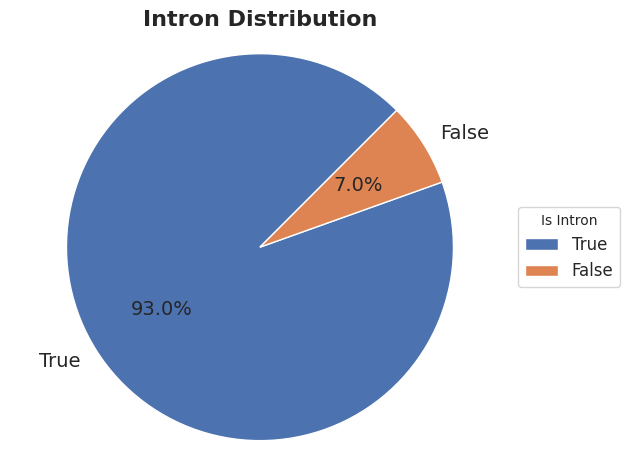

In [3]:
# Count the occurrences of each category
intron_counts = df[~(df["gene_name"] == "not_found")].is_intron.value_counts()

# Create the pie chart
fig, ax = plt.subplots()
ax.pie(intron_counts, labels=intron_counts.index, autopct='%1.1f%%', startangle=45, textprops={'fontsize': 14})

ax.set_title('Intron Distribution', fontsize=16, fontweight='bold')
ax.axis('equal')
ax.legend(title='Is Intron', loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [4]:
driver_oncogenes = set(df[(df.is_driver) & (df.is_oncogene)].gene_name.unique().tolist())
driver_tsupps = set(df[(df.is_driver) & (df.is_tumor_suppressor)].gene_name.unique().tolist())

only_driver_oncogenes = driver_oncogenes - driver_tsupps
only_driver_tsupps = driver_tsupps - driver_oncogenes
crossections = driver_oncogenes & driver_tsupps


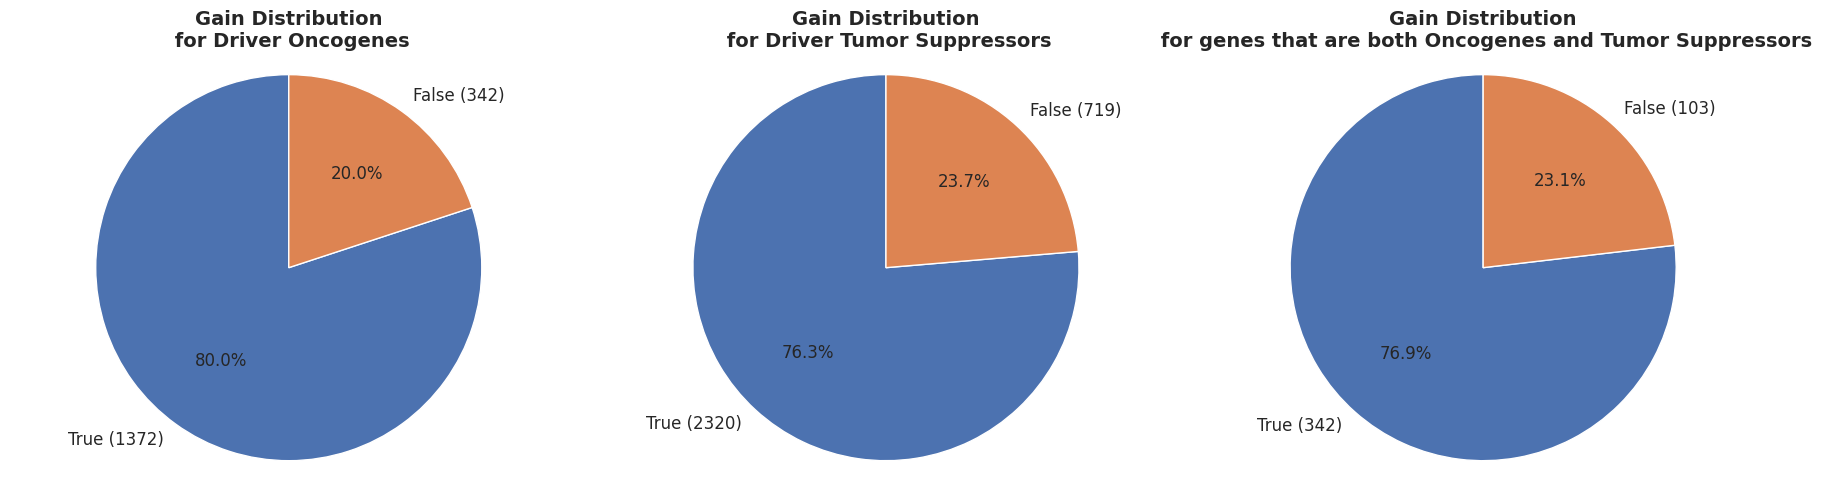

In [5]:

oncogene_gain_counts = df[df.gene_name.isin(only_driver_oncogenes)].is_gain.value_counts()
tsupp_gain_counts = df[df.gene_name.isin(only_driver_tsupps)].is_gain.value_counts()
both_gain_counts = df[df.gene_name.isin(crossections)].is_gain.value_counts()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

ax1.pie(oncogene_gain_counts, labels=[f"{label} ({count})" for label, count in oncogene_gain_counts.items()],
        autopct='%1.1f%%', startangle=90, textprops={'fontsize': 12})
ax1.set_title('Gain Distribution\n for Driver Oncogenes', fontsize=14, fontweight='bold')
ax1.axis('equal')

ax2.pie(tsupp_gain_counts, labels=[f"{label} ({count})" for label, count in tsupp_gain_counts.items()],
        autopct='%1.1f%%', startangle=90, textprops={'fontsize': 12})
ax2.set_title('Gain Distribution\n for Driver Tumor Suppressors', fontsize=14, fontweight='bold')
ax2.axis('equal')

ax3.pie(both_gain_counts, labels=[f"{label} ({count})" for label, count in both_gain_counts.items()],
        autopct='%1.1f%%', startangle=90, textprops={'fontsize': 12})
ax3.set_title('Gain Distribution\n for genes that are both Oncogenes and Tumor Suppressors', fontsize=14, fontweight='bold')
ax3.axis('equal')

plt.tight_layout()
plt.show()


# count plots

In [6]:
import plotly.graph_objects as go

def plot_grouped_counts(df, filter_expr, column):
    # Get the value counts for the filtered data
    filtered_counts = df[filter_expr].groupby("is_gain")[column].value_counts().unstack(level=0)
    filtered_counts = filtered_counts.unstack(level=0)

    # Fill missing values with 0
    filtered_counts = filtered_counts.fillna(0)
    filtered_counts = filtered_counts.sort_values(ascending=False)

    # Get the unique mutsig values
    mutsig_values = filtered_counts.index.get_level_values(column).unique()

    # Create traces for each mutsig value
    traces = []
    for mutsig in mutsig_values:
        trace = go.Bar(
            name=mutsig,
            x=['True', 'False'],
            y=[filtered_counts.loc[(True, mutsig)], filtered_counts.loc[(False, mutsig)]],
            text=[filtered_counts.loc[(True, mutsig)], filtered_counts.loc[(False, mutsig)]],
            textposition='auto'
        )
        traces.append(trace)

    # Create the layout for the plot
    layout = go.Layout(
        title='Grouped Counts',
        xaxis=dict(title='is_gain'),
        yaxis=dict(title='Count'),
        barmode='stack'
    )

    # Create the figure and add the traces
    fig = go.Figure(data=traces, layout=layout)

    # Display the interactive plot
    fig.show()




In [24]:
filter_arg = df.gene_name.isin(driver_oncogenes)
plot_grouped_counts(df, filter_arg, "mutation_context")



# tug of war?

In [8]:
is_driver_oncogene = (df.is_oncogene) & ~(df.is_tumor_suppressor) & (df.is_driver)
is_driver_tsupp = ~(df.is_oncogene) & (df.is_tumor_suppressor) & (df.is_driver)
is_gene_upregulated = ~df.is_gain
is_gene_downregulated = df.is_gain

conf_matrix = pd.DataFrame(index=['Upregulated', 'Downregulated'], columns=['Oncogene', 'Tumor Suppressor'])

conf_matrix.at['Upregulated', 'Oncogene'] = ((is_driver_oncogene) & (is_gene_upregulated)).sum()
conf_matrix.at['Downregulated', 'Oncogene'] = ((is_driver_oncogene) & (is_gene_downregulated)).sum()
conf_matrix.at['Upregulated', 'Tumor Suppressor'] = ((is_driver_tsupp) & (is_gene_upregulated)).sum()
conf_matrix.at['Downregulated', 'Tumor Suppressor'] = ((is_driver_tsupp) & (is_gene_downregulated)).sum()

conf_matrix


,Oncogene,Tumor Suppressor
Upregulated,342,719
Downregulated,1372,2320


In [9]:
import pandas as pd

# Assuming df is your original DataFrame

# Conditions
is_driver_oncogene = (df.is_oncogene) & ~(df.is_tumor_suppressor) & (df.is_driver)
is_driver_tsupp = ~(df.is_oncogene) & (df.is_tumor_suppressor) & (df.is_driver)
is_gene_upregulated = ~df.is_gain
is_gene_downregulated = df.is_gain

# Creating a DataFrame to hold the confusion matrix
conf_matrix = pd.DataFrame(index=['Upregulated', 'Downregulated', 'Percentage Upregulated'], columns=['Oncogene', 'Tumor Suppressor'])

# Filling the confusion matrix
conf_matrix.at['Upregulated', 'Oncogene'] = ((is_driver_oncogene) & (is_gene_upregulated)).sum()
conf_matrix.at['Downregulated', 'Oncogene'] = ((is_driver_oncogene) & (is_gene_downregulated)).sum()
conf_matrix.at['Upregulated', 'Tumor Suppressor'] = ((is_driver_tsupp) & (is_gene_upregulated)).sum()
conf_matrix.at['Downregulated', 'Tumor Suppressor'] = ((is_driver_tsupp) & (is_gene_downregulated)).sum()

# Calculate the total number of genes in each category
total_oncogene = conf_matrix.at['Upregulated', 'Oncogene'] + conf_matrix.at['Downregulated', 'Oncogene']
total_tsupp = conf_matrix.at['Upregulated', 'Tumor Suppressor'] + conf_matrix.at['Downregulated', 'Tumor Suppressor']

# Calculate the percentage of upregulated genes
conf_matrix.at['Percentage Upregulated', 'Oncogene'] = (conf_matrix.at['Upregulated', 'Oncogene'] / total_oncogene) * 100 if total_oncogene > 0 else 0
conf_matrix.at['Percentage Upregulated', 'Tumor Suppressor'] = (conf_matrix.at['Upregulated', 'Tumor Suppressor'] / total_tsupp) * 100 if total_tsupp > 0 else 0

print(conf_matrix)
print(f"overall percent upregulated/downregulated: {len(df[~df.is_gain]) / len(df[df.is_gain])}")
print(f"overall percent of driver upregulated/downregulated: {len(df[df.is_driver & ~df.is_gain]) / len(df[df.is_driver & df.is_gain])}")



                         Oncogene Tumor Suppressor
Upregulated                   342              719
Downregulated                1372             2320
Percentage Upregulated  19.953326        23.659098
overall percent upregulated/downregulated: 0.3406758863722736
overall percent of driver upregulated/downregulated: 0.32642089093702


# up&down percentages per attributes

In [10]:
df["is_gene_upregulated"] = ~df.is_gain
df["is_gene_downregulated"] = df.is_gain

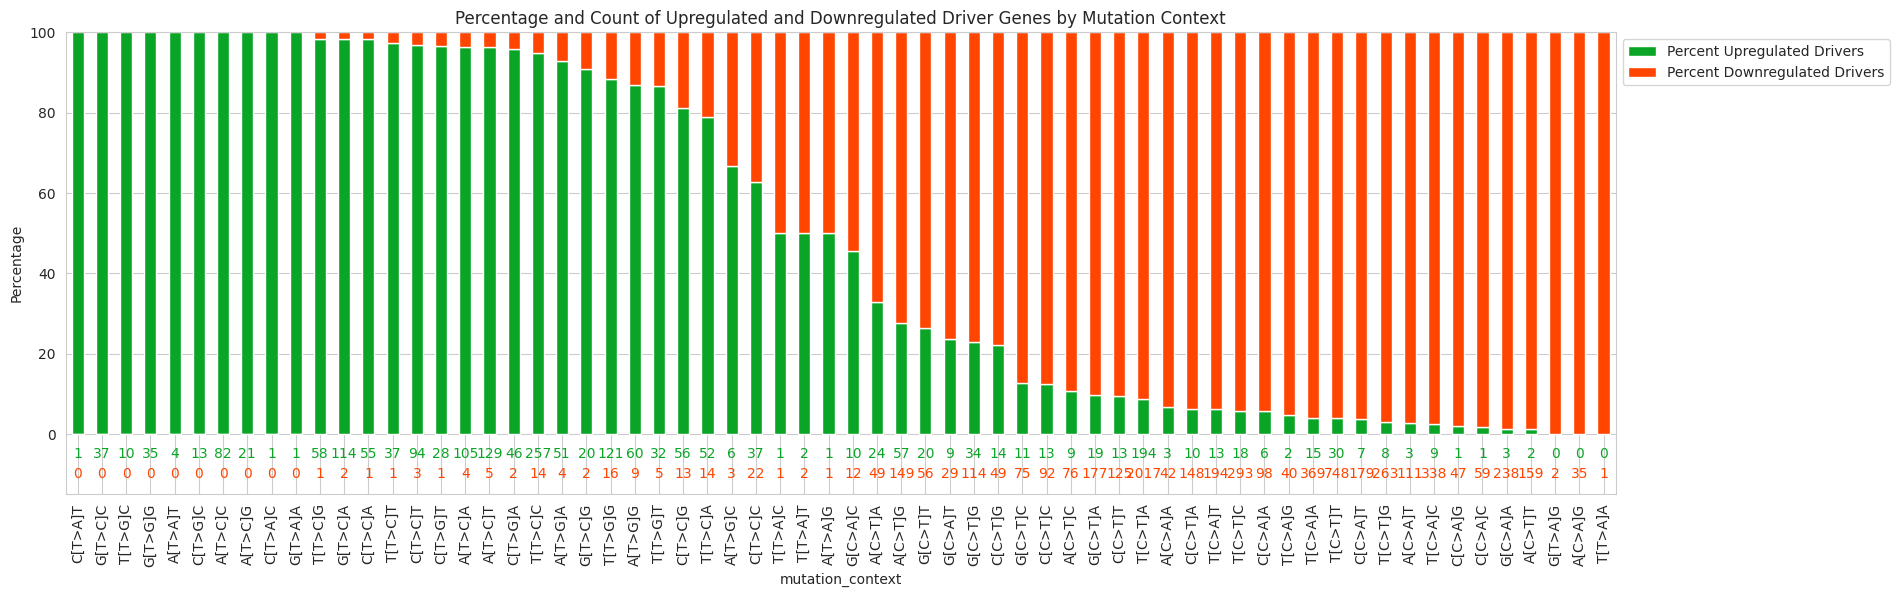

In [11]:

mutation_context_analysis = df[df['is_driver']].groupby('mutation_context').apply(
    lambda x: pd.Series({
        'Percent Upregulated Drivers': (x['is_gene_upregulated'].sum() / len(x)) * 100,
        'Percent Downregulated Drivers': (x['is_gene_downregulated'].sum() / len(x)) * 100,
        'Count Upregulated Drivers': x['is_gene_upregulated'].sum(),
        'Count Downregulated Drivers': x['is_gene_downregulated'].sum()
    }), include_groups=False
).sort_values(by='Percent Upregulated Drivers', ascending=False).reset_index()

# Define colors for the bars
colors = ['#0aa527', '#ff4500']

# Plotting the stacked bar chart with specified colors
ax = mutation_context_analysis.plot(x='mutation_context', y=['Percent Upregulated Drivers', 'Percent Downregulated Drivers'], kind='bar', stacked=True, figsize=(20, 6), color=colors)

# Adding the counts below the x-axis labels with matching colors
for i, row in mutation_context_analysis.iterrows():
    # Position for the upregulated drivers count, using the first color
    plt.text(i, -5, f"{int(row['Count Upregulated Drivers'])}", ha='center', va='center', color=colors[0], fontsize=10)
    # Position for the downregulated drivers count, using the second color
    plt.text(i, -10, f"{int(row['Count Downregulated Drivers'])}", ha='center', va='center', color=colors[1], fontsize=10)

plt.xticks(rotation=90)
plt.ylabel('Percentage')
plt.title('Percentage and Count of Upregulated and Downregulated Driver Genes by Mutation Context')
plt.ylim(-15, 100)  # Adjust the y-axis limit to make space for the text annotations
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


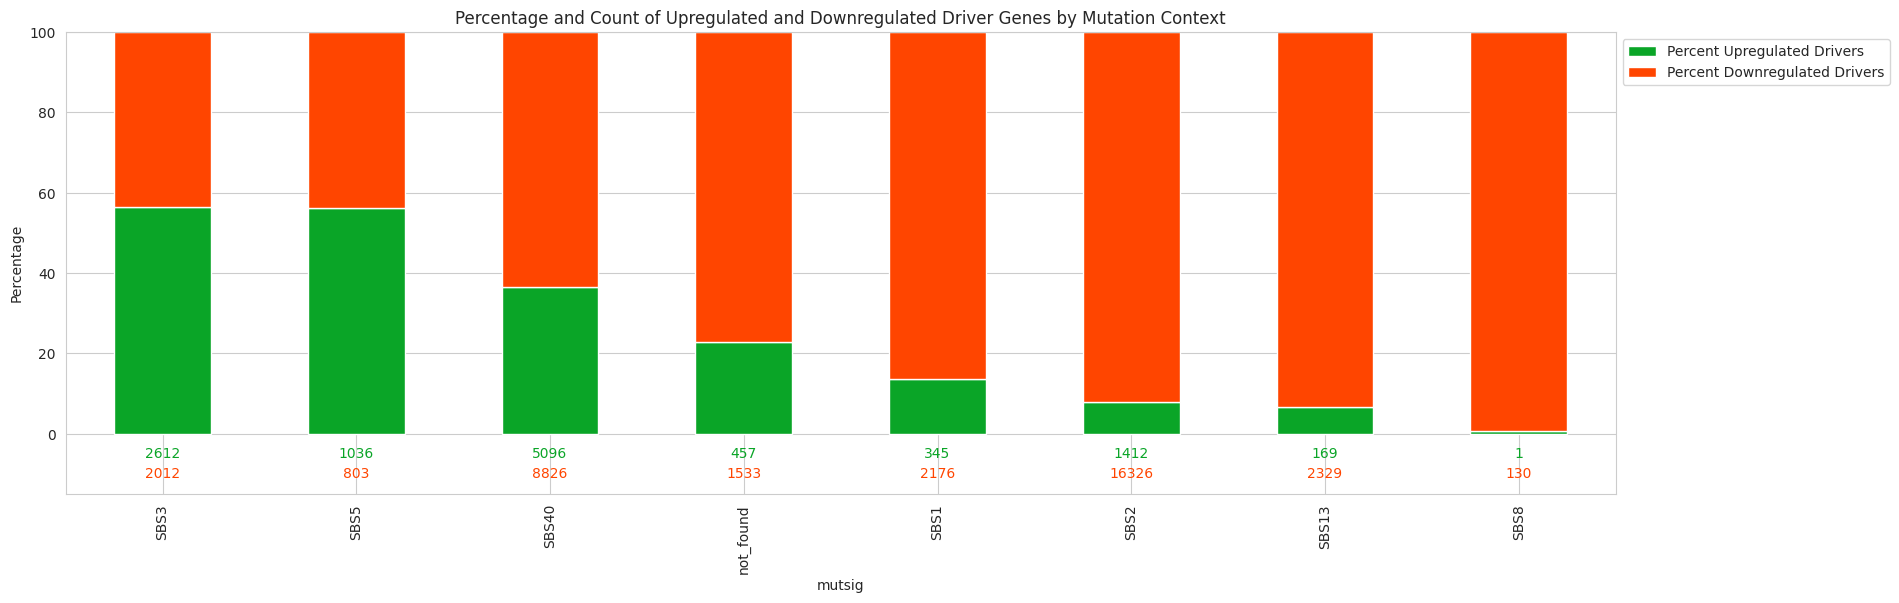

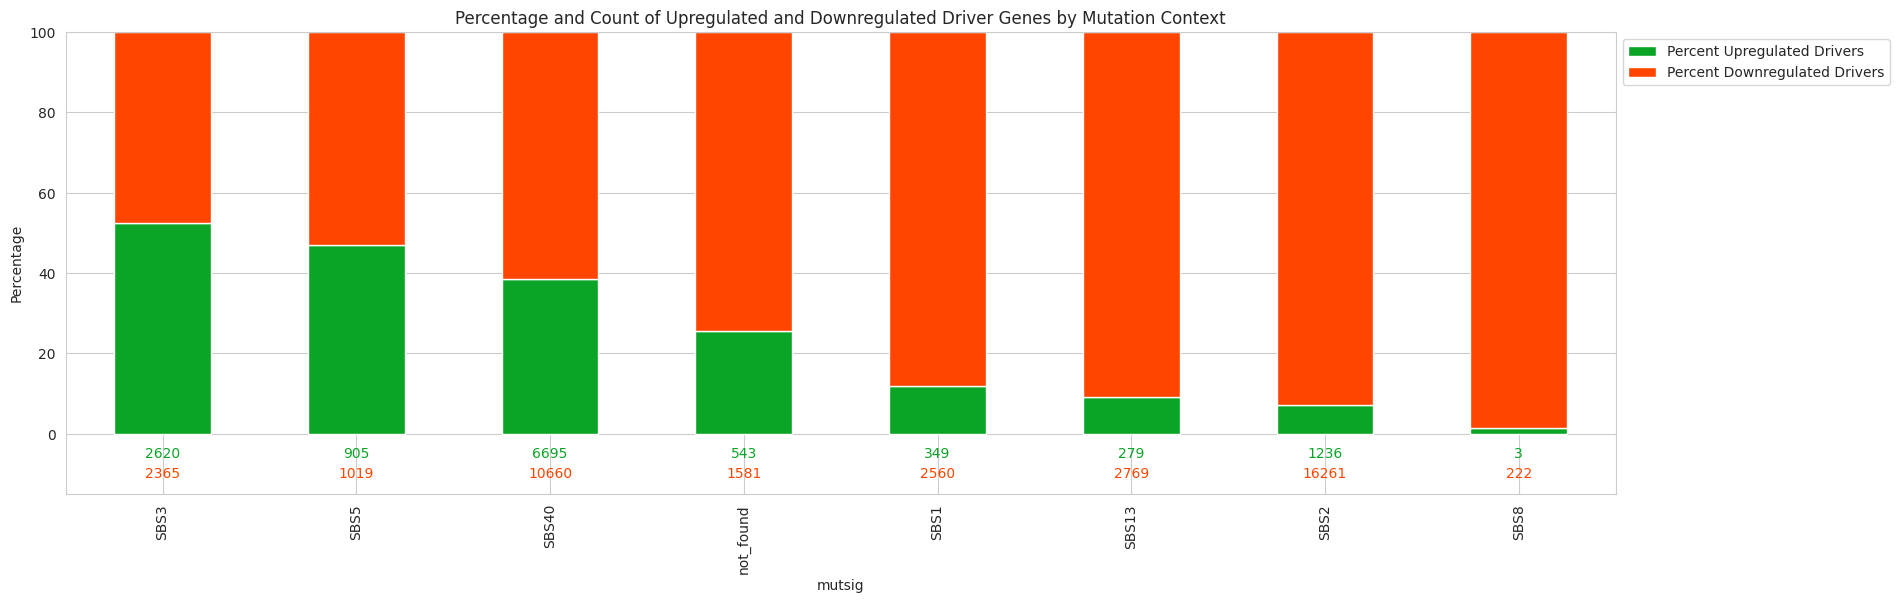

In [29]:

mutsig_analysis = df[df['is_oncogene']].groupby('mutsig').apply(
    lambda x: pd.Series({
        'Percent Upregulated Drivers': (x['is_gene_upregulated'].sum() / len(x)) * 100,
        'Percent Downregulated Drivers': (x['is_gene_downregulated'].sum() / len(x)) * 100,
        'Count Upregulated Drivers': x['is_gene_upregulated'].sum(),
        'Count Downregulated Drivers': x['is_gene_downregulated'].sum()
    }), include_groups=False
).sort_values(by='Percent Upregulated Drivers', ascending=False).reset_index()

# Define colors for the bars
colors = ['#0aa527', '#ff4500']

# Plotting the stacked bar chart with specified colors
ax = mutsig_analysis.plot(x='mutsig', y=['Percent Upregulated Drivers', 'Percent Downregulated Drivers'], kind='bar', stacked=True, figsize=(20, 6), color=colors)

# Adding the counts below the x-axis labels with matching colors
for i, row in mutsig_analysis.iterrows():
    # Position for the upregulated drivers count, using the first color
    plt.text(i, -5, f"{int(row['Count Upregulated Drivers'])}", ha='center', va='center', color=colors[0], fontsize=10)
    # Position for the downregulated drivers count, using the second color
    plt.text(i, -10, f"{int(row['Count Downregulated Drivers'])}", ha='center', va='center', color=colors[1], fontsize=10)

plt.xticks(rotation=90)
plt.ylabel('Percentage')
plt.title('Percentage and Count of Upregulated and Downregulated Driver Genes by Mutation Context')
plt.ylim(-15, 100)  # Adjust the y-axis limit to make space for the text annotations
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()



mutsig_analysis = df[df['is_tumor_suppressor']].groupby('mutsig').apply(
    lambda x: pd.Series({
        'Percent Upregulated Drivers': (x['is_gene_upregulated'].sum() / len(x)) * 100,
        'Percent Downregulated Drivers': (x['is_gene_downregulated'].sum() / len(x)) * 100,
        'Count Upregulated Drivers': x['is_gene_upregulated'].sum(),
        'Count Downregulated Drivers': x['is_gene_downregulated'].sum()
    }), include_groups=False
).sort_values(by='Percent Upregulated Drivers', ascending=False).reset_index()

# Define colors for the bars
colors = ['#0aa527', '#ff4500']

# Plotting the stacked bar chart with specified colors
ax = mutsig_analysis.plot(x='mutsig', y=['Percent Upregulated Drivers', 'Percent Downregulated Drivers'], kind='bar', stacked=True, figsize=(20, 6), color=colors)

# Adding the counts below the x-axis labels with matching colors
for i, row in mutsig_analysis.iterrows():
    # Position for the upregulated drivers count, using the first color
    plt.text(i, -5, f"{int(row['Count Upregulated Drivers'])}", ha='center', va='center', color=colors[0], fontsize=10)
    # Position for the downregulated drivers count, using the second color
    plt.text(i, -10, f"{int(row['Count Downregulated Drivers'])}", ha='center', va='center', color=colors[1], fontsize=10)

plt.xticks(rotation=90)
plt.ylabel('Percentage')
plt.title('Percentage and Count of Upregulated and Downregulated Driver Genes by Mutation Context')
plt.ylim(-15, 100)  # Adjust the y-axis limit to make space for the text annotations
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


In [13]:
mirna_family_analysis = df[df['is_driver']].groupby('mirna_family').apply(
    lambda x: pd.Series({
        'Percent Upregulated Drivers': (x['is_gene_upregulated'].sum() / len(x)) * 100,
        'Percent Downregulated Drivers': (x['is_gene_downregulated'].sum() / len(x)) * 100,
        'Count Upregulated Drivers': x['is_gene_upregulated'].sum(),
        'Count Downregulated Drivers': x['is_gene_downregulated'].sum(),
        'total': x['is_gene_upregulated'].sum() + x['is_gene_downregulated'].sum()  # Adding total count
    }), include_groups=False
).sort_values(by='total', ascending=False).reset_index()

mirna_family_analysis


,mirna_family,Percent Upregulated Drivers,Percent Downregulated Drivers,Count Upregulated Drivers,Count Downregulated Drivers,total
0,let-7-5p/98-5p,14.035088,85.964912,8.0,49.0,57.0
1,miR-548ay-5p/548au-5p/548as-5p/548ar-5p/548aq-...,37.500000,62.500000,21.0,35.0,56.0
2,miR-378-3p,10.416667,89.583333,5.0,43.0,48.0
3,miR-302-3p/372-3p/373-3p/520-3p,24.444444,75.555556,11.0,34.0,45.0
4,miR-17-5p/20-5p/93-5p/106-5p/519-3p,33.333333,66.666667,13.0,26.0,39.0
...,...,...,...,...,...,...
1890,miR-4634,100.000000,0.000000,1.0,0.0,1.0
1891,miR-6799-5p,100.000000,0.000000,1.0,0.0,1.0
1892,miR-588,0.000000,100.000000,0.0,1.0,1.0
1893,miR-6798-3p,100.000000,0.000000,1.0,0.0,1.0


# tsuppların yüzde kaçında gain fazla, vice versa, sbs based bak bakalım, ve sonra agg bak
# 

In [14]:

def calculate_mutation_percentages(df, gene_type, attr_col):

    return (
        df[df[gene_type] == 1]
        .groupby([attr_col, 'is_gain'])['is_gain']
        .value_counts()
        .rename({1: 'no_downregulated', 0: 'no_upregulated'})
        .reset_index()
        .pivot_table(
            index=attr_col,
            columns='is_gain',
            values='is_gain',
            aggfunc='sum',
            fill_value=0,
        )
        .assign(total=lambda x: x['no_downregulated'] + x['no_upregulated'])
        .reset_index()
        .rename_axis(None, axis=1)
        .assign(
            percent_downregulated=lambda x: x['no_downregulated']
            / x['total']
            * 100
        )
        .assign(
            percent_upregulated=lambda x: x['no_upregulated']
            / x['total']
            * 100
        )
        .sort_values(by=['percent_downregulated'], ascending=False)
    )


In [15]:
print("Tumor suppressor genes' up & downregulation percentages per mutation_context")
calculate_mutation_percentages(df, 'is_tumor_suppressor', 'mutation_context')


Tumor suppressor genes' up & downregulation percentages per mutation_context


,mutation_context,no_downregulated,no_upregulated,total,percent_downregulated,percent_upregulated
49,G[T>A]G,1,0,1,100.000000,0.000000
3,A[C>A]T,994,26,1020,97.450980,2.549020
7,A[C>T]T,534,19,553,96.564195,3.435805
23,C[C>A]T,380,20,400,95.000000,5.000000
59,T[C>A]C,1255,68,1323,94.860166,5.139834
...,...,...,...,...,...,...
56,G[T>G]G,6,253,259,2.316602,97.683398
36,C[T>G]A,2,91,93,2.150538,97.849462
39,C[T>G]T,6,294,300,2.000000,98.000000
19,A[T>G]T,2,156,158,1.265823,98.734177


In [16]:
print("Tumor suppressor genes' up & downregulation percentages per mutsig")
calculate_mutation_percentages(df, 'is_tumor_suppressor', 'mutsig')


Tumor suppressor genes' up & downregulation percentages per mutsig


,mutsig,no_downregulated,no_upregulated,total,percent_downregulated,percent_upregulated
6,SBS8,222,3,225,98.666667,1.333333
2,SBS2,16261,1236,17497,92.935932,7.064068
1,SBS13,2769,279,3048,90.846457,9.153543
0,SBS1,2560,349,2909,88.002750,11.997250
7,not_found,1581,543,2124,74.435028,25.564972
4,SBS40,10660,6695,17355,61.423221,38.576779
5,SBS5,1019,905,1924,52.962578,47.037422
3,SBS3,2365,2620,4985,47.442327,52.557673


In [17]:
print("Tumor suppressor genes' up & downregulation percentages per mirna_family")
calculate_mutation_percentages(df, 'is_tumor_suppressor', 'mirna_family')


Tumor suppressor genes' up & downregulation percentages per mirna_family


,mirna_family,no_downregulated,no_upregulated,total,percent_downregulated,percent_upregulated
1845,miR-6840-3p,4,0,4,100.0,0.0
91,miR-12136_pred,2,0,2,100.0,0.0
825,miR-4284,5,0,5,100.0,0.0
1678,miR-6726-3p,1,0,1,100.0,0.0
1374,miR-545-3p,8,0,8,100.0,0.0
...,...,...,...,...,...,...
703,miR-3714,0,2,2,0.0,100.0
519,miR-3154,0,1,1,0.0,100.0
1721,miR-6753-5p,0,3,3,0.0,100.0
632,miR-3615,0,3,3,0.0,100.0


In [18]:
calculate_mutation_percentages(df, 'is_tumor_suppressor', 'mirna_family')

,mirna_family,no_downregulated,no_upregulated,total,percent_downregulated,percent_upregulated
1845,miR-6840-3p,4,0,4,100.0,0.0
91,miR-12136_pred,2,0,2,100.0,0.0
825,miR-4284,5,0,5,100.0,0.0
1678,miR-6726-3p,1,0,1,100.0,0.0
1374,miR-545-3p,8,0,8,100.0,0.0
...,...,...,...,...,...,...
703,miR-3714,0,2,2,0.0,100.0
519,miR-3154,0,1,1,0.0,100.0
1721,miR-6753-5p,0,3,3,0.0,100.0
632,miR-3615,0,3,3,0.0,100.0


In [19]:
df["gain"] = df.mut_prediction > df.wt_prediction
df["loss"] = df.mut_prediction < df.wt_prediction

# comut

In [20]:
from comut import comut
from comut import fileparsers
toy_comut = comut.CoMut()



In [21]:
df.nunique().sort_values(ascending=False)

id                       3608889
wt_prediction            2893749
mut_prediction           2745277
gene_id                    14753
gene_name                  14747
gene_description           11751
mirna_accession             2656
mirna_name                  2656
seed                        2162
mirna_family                2105
pred_difference             1209
mutation_context              80
vcf_id                        21
gene_biotype                  20
mutsig                         8
is_oncogene                    2
is_tumor_suppressor            2
is_cosmic_tier_1               2
is_driver                      2
is_gain                        2
is_intron                      2
is_gene_upregulated            2
is_gene_downregulated          2
gain                           2
loss                           2
dtype: int64

/tmp/ipykernel_8806/2855270468.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



KeyError: 'plot1'

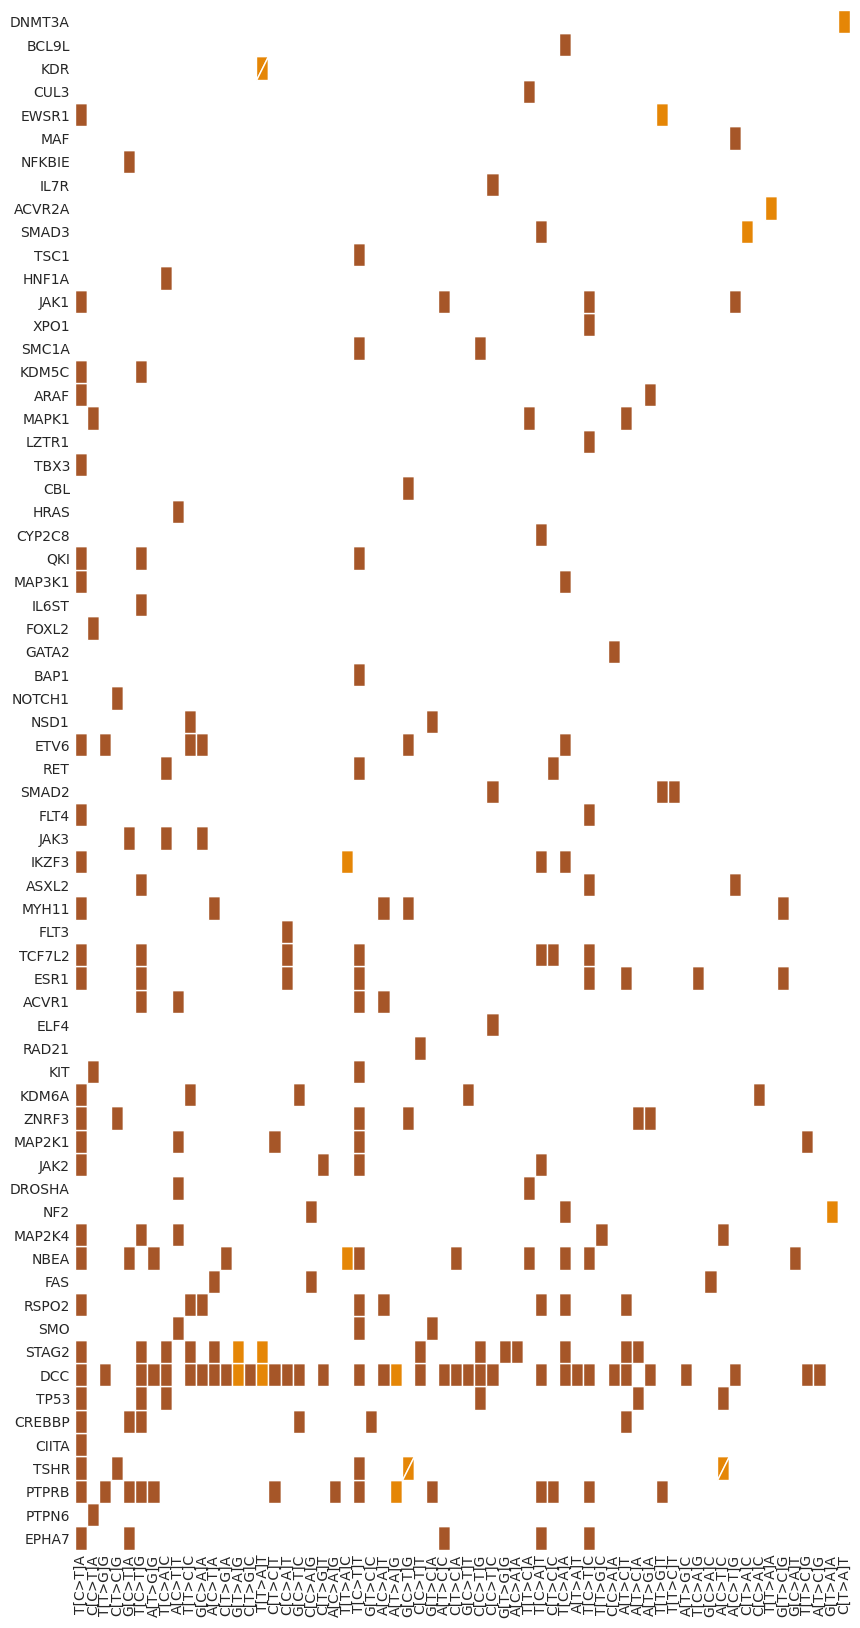

In [23]:
data = df[df.is_driver]

data.rename(columns = {"mutation_context": "sample", # bottom
                       "gene_name": "category", # left
                       "gene_biotype": "value"}, inplace = True) # categories

toy_comut = comut.CoMut()
toy_comut.add_categorical_data(data)
toy_comut.plot_comut(figsize = (10,20))
toy_comut.add_categorical_data(data[data.is_tumor_suppressor], name='plot1')
toy_comut.add_unified_legend()

In [34]:
len(df.gene_biotype.value_counts()
)

20

In [40]:
len(df[(df.is_gene_upregulated) & (df.is_oncogene)]) / len(df[(df.is_gene_downregulated) & (df.is_oncogene)])

0.3259997070455544

In [44]:
len(df[(df.is_gene_upregulated) & (df.is_tumor_suppressor)]) / len(df[(df.is_gene_downregulated) & (df.is_tumor_suppressor)])


0.3373667761839891

In [54]:
len(df[df.is_oncogene].gene_name.unique())


286

In [68]:
set(genes[genes.is_oncogene].gene_name.unique().tolist()) - set(df[df.is_oncogene].gene_name.unique().tolist())

{'ACKR3',
 'ALOX12B',
 'APLNR',
 'AURKB',
 'BCL9',
 'CAD',
 'CANT1',
 'CCND1',
 'CCNE1',
 'CD19',
 'CD274',
 'CD276',
 'CD70',
 'CD74',
 'CD79A',
 'CD79B',
 'CDK4',
 'CRLF2',
 'CSF3R',
 'CTLA4',
 'CTNNB1',
 'CXCR4',
 'CXorf67',
 'CYSLTR2',
 'DDX5',
 'EGFL7',
 'EIF4A2',
 'ELF3',
 'ELK4',
 'ELN',
 'EPOR',
 'ERBB3',
 'ETV4',
 'EZH1',
 'EZH2',
 'FGF19',
 'FGF23',
 'FGF3',
 'FGF4',
 'FGFR3',
 'FOXA1',
 'FOXF1',
 'FURIN',
 'FUS',
 'GNB1',
 'GRB7',
 'GREM1',
 'GTF2I',
 'H3F3A',
 'HFE',
 'HIST1H1E',
 'HMGA1',
 'HOXB13',
 'HSD3B1',
 'ICOSLG',
 'ID1',
 'IDH1',
 'IDH2',
 'IGF1',
 'IGF2',
 'IKBKE',
 'IL3',
 'JUN',
 'KDM5D',
 'KEL',
 'KLF4',
 'KRAS',
 'LCK',
 'LMO1',
 'LTB',
 'MAD2L2',
 'MAFB',
 'MAP2K2',
 'MAPK3',
 'MCL1',
 'MEF2B',
 'MEF2D',
 'MST1R',
 'MTHFD2',
 'MYCL',
 'MYD88',
 'NADK',
 'NCSTN',
 'NFE2',
 'NKX2-1',
 'NRAS',
 'PDCD1',
 'PDCD1LG2',
 'PGR',
 'PHF19',
 'PLCG1',
 'POU3F2',
 'POU3F4',
 'PRKACA',
 'RAC1',
 'RAC2',
 'RBM15',
 'RNASEH2A',
 'ROS1',
 'RPS15',
 'RPS6KA4',
 'RPS6KB2',
 'R

In [69]:
genes[genes.gene_name == "CD274"]


,gene_id,gene_name,chr,start,end,gene_biotype,gene_description,is_oncogene,is_tumor_suppressor,is_cosmic_tier_1,is_driver
28592,ENSG00000120217,CD274,9,5450503,5470566,protein_coding,CD274 molecule [Source:HGNC Symbol;Acc:17635],True,False,True,True


In [70]:
df[df.gene_name == "CD274"]

,id,wt_prediction,mut_prediction,pred_difference,vcf_id,mirna_accession,gene_id,mutation_context,mutsig,is_intron,is_gain,gene_name,gene_biotype,gene_description,is_oncogene,is_tumor_suppressor,is_cosmic_tier_1,is_driver,mirna_name,mirna_family,seed,is_gene_upregulated,is_gene_downregulated,gain,loss


In [62]:
len(genes[genes.is_oncogene].gene_name.unique())


413

In [63]:
len(genes[genes.is_cosmic_tier_1].gene_name.unique())


574

In [55]:
len(df[df.is_tumor_suppressor].gene_name.unique()
)

246

In [60]:
len(genes[genes.is_tumor_suppressor].gene_name.unique())


365

In [58]:
df[df.is_driver].gene_name.nunique()


66

In [57]:
genes[genes.is_driver].gene_name.nunique()


87